# Data import

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from easymoney.money import EasyPeasy
import sklearn.model_selection as sk
import warnings
warnings.filterwarnings('ignore')

Helper functions

In [2]:
def split_profession(x):
    if type(x) == str:
        return str(x).split(',')
    else:
        return np.nan

def cast_count(cast_age):
    return len(cast_age[~np.isnan(cast_age)])

def keep_numbers(revenue):
    """Function to convert revenue string to a number, we only do it for revenue in dollars
    Because we did not manage to find conversion rates for movies from <2000"""
    if revenue == None or revenue[0] != '$':
        return np.nan
    return int(re.sub("[^0-9]","", str(revenue)))

def bootstrap_mean_ci(data, percentile, n_sample):
    
    sample_means = []
    for i in range(n_sample):
        sample = np.random.choice(data, len(data))
        sample_means.append(np.nanmean(sample))
    
    return [np.round(np.percentile(sample_means, percentile), 3), \
            np.round(np.percentile(sample_means, 100-percentile), 3)]

def bootstrap_median_ci(data, percentile, n_sample):
    
    sample_medians = []
    for i in range(n_sample):
        sample = np.random.choice(data, len(data))
        sample_medians.append(np.nanmedian(sample))
    
    return [np.round(np.percentile(sample_medians, percentile), 3), \
            np.round(np.percentile(sample_medians, 100-percentile), 3)]

def normalize_inflation(revenue, year):
    """Take inflation into account, no data available before 1960 """
    if np.isnan(revenue) or np.isnan(year) or year < 1960:
        return np.nan
    return ep.normalize(amount=revenue, region="US", from_year=year, to_year="latest", base_currency="USD")

normalize_inflation = np.vectorize(normalize_inflation)

def df_crossjoin(df):
    df['tmpkey'] = 1
    res = pd.merge(df, df, on='tmpkey').drop('tmpkey', axis=1)
    df.drop('tmpkey', axis=1, inplace=True)
    return res


def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return np.round(len(s1.intersection(s2)) / len(s1.union(s2)),2)

In [3]:
#scraped files
movies = pd.read_pickle('pickles/complete_movies.pkl')
cast = pd.read_pickle('pickles/complete_cast.pkl') 

#files downloaded from the imdb website
movies_file = pd.read_csv('data/title.basics.tsv', sep='\t', na_values= '\\N')
people_file = pd.read_csv('data/name.basics.tsv.gz', sep='\t', converters={'primaryProfession': split_profession},\
                        na_values= '\\N')
movie_ratings = pd.read_csv("data/title.ratings.tsv.gz", sep='\t')

We merge the information from the imdb files with the scraped information

In [4]:
movies_file = movies_file[movies_file['titleType'] == 'movie']
movies_file = movies_file.drop(['titleType', 'endYear'], axis=1)
movies = movies.merge(movies_file, how='outer', on='tconst')

###### We start by checking if the years from the scraping and the imdb files are the same

In [5]:
# We extract the year from the datetime variables
date_to_year = [lambda x: np.nan if (x == None) else x.year]
movies['testYear'] = movies['releaseDate'].apply(date_to_year)

diffs = (movies['testYear'] - movies['startYear'])
print('There is {} movies where the scraped year is not the same as in the files'\
      .format((diffs != 0.0).sum()-(diffs.isna()).sum()))

There is 32639 movies where the scraped year is not the same as in the files


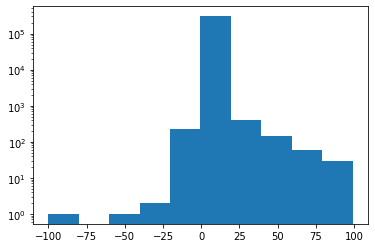

In [6]:
plt.hist(diffs[~np.isnan(diffs)]);
plt.yscale('log', nonposy='clip')

###### We use the scraped cast to get an median age of each cast, we do not use an average as the data contains a lot of outliers.

In [7]:
people_file = people_file.explode('primaryProfession')
cast = cast.explode('cast')
people_year = people_file.drop(['primaryName', 'deathYear', 'primaryProfession', 'knownForTitles'], axis=1)
cast = cast.merge(people_year, how='inner', left_on = 'cast', right_on = 'nconst')

We make a new feature; when the year is missing in the scraped file we take the year from the scraping

In [8]:
movies['Year'] = np.where(np.isnan(movies['startYear']), movies['testYear'], movies['startYear'])
movies_year = movies[['tconst', 'Year']]

cast = cast.merge(movies_year, how='inner', on = 'tconst')

Sanity check

In [9]:
cast['cast'].isna().sum()

0

In [10]:
cast['tconst'].isna().sum()

0

We remove the duplicates

In [11]:
(cast[['tconst', 'cast']].duplicated()).sum()

4120666

In [12]:
cast = cast.drop_duplicates(subset=['tconst', 'cast'])

In [13]:
cast[cast['birthYear'] < 1830]['birthYear'].value_counts()

4.0       17
1828.0     7
1810.0     3
1823.0     2
1812.0     2
21.0       2
1805.0     2
1757.0     2
1792.0     2
1818.0     2
1766.0     2
12.0       1
1483.0     1
1769.0     1
1802.0     1
1815.0     1
1795.0     1
1791.0     1
1067.0     1
1829.0     1
1827.0     1
1641.0     1
1821.0     1
1798.0     1
1822.0     1
1814.0     1
1799.0     1
1819.0     1
Name: birthYear, dtype: int64

###### We remove the obvious outliers like birthYear < 1800

In [14]:
cast['birthYear'] = np.where(cast['birthYear'] < 1800, np.nan, cast['birthYear'])

We introduce the Age variable, we compute it from the Year of the movies file/scraping and the birthYear of people file

In [15]:
cast['Age'] = cast['Year'] - cast['birthYear']

We check for outliers

In [16]:
(cast['Age'] < 0).sum()

530

In [17]:
(cast['Age'] > 100).sum()

6737

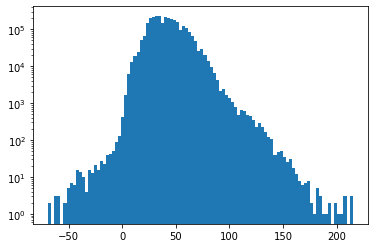

In [18]:
ages = cast['Age'].values
plt.hist(ages[~np.isnan(ages)], bins=100);
plt.yscale('log', nonposy='clip')

In [19]:
cast_ages = cast.groupby(['tconst'])['Age'].agg([np.nanmedian, cast_count])
cast_ages = cast_ages.rename(columns={'nanmedian': 'custom_median'})

In [20]:
cast_ages.head()

,custom_median,cast_count
tconst,,
tt0000009,19.0,3.0
tt0000147,39.0,5.0
tt0000335,11.0,2.0
tt0000502,NaN,0.0
tt0000574,28.0,6.0


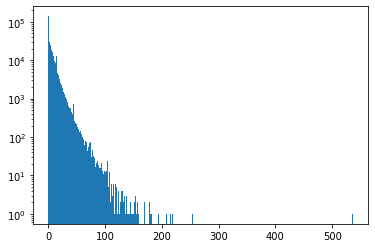

In [21]:
plt.hist(cast_ages['cast_count'], bins=500);
plt.yscale('log', nonposy='clip')

We only take the information if we have more than 10 persons in the cast

In [22]:
cast_ages['credible_median'] = np.where(cast_ages['cast_count'] > 10, cast_ages['custom_median'], np.nan)

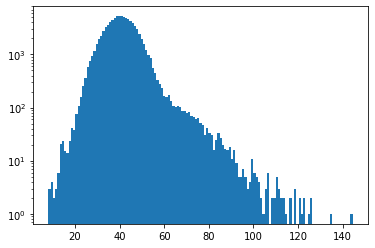

In [23]:
credible_median_ages = cast_ages['credible_median'].values
plt.hist(credible_median_ages[~np.isnan(credible_median_ages)], bins = 135);
plt.yscale('log', nonposy='clip')

We see that we do not have the negative age outliers but we still have suspiciously high values

In [24]:
cast_ages.nlargest(10, 'credible_median')

,custom_median,cast_count,credible_median
tconst,,,
tt6454944,144.5,30.0,144.5
tt6490038,135.0,11.0,135.0
tt1646939,126.0,11.0,126.0
tt3587202,126.0,17.0,126.0
tt0212457,125.0,11.0,125.0
tt3188516,123.0,13.0,123.0
tt3526810,123.0,13.0,123.0
tt10443162,122.0,43.0,122.0
tt2161168,121.0,20.0,121.0


The high values come from recent documentaries using archive footage or reconstruction of very old films.

In [25]:
cast_ages.nsmallest(10, 'credible_median')

,custom_median,cast_count,credible_median
tconst,,,
tt0201347,8.0,27.0,8.0
tt0008144,9.0,17.0,9.0
tt0110366,9.0,34.0,9.0
tt0007617,9.5,14.0,9.5
tt0009721,9.5,14.0,9.5
tt0117008,10.0,44.0,10.0
tt0124879,10.0,35.0,10.0
tt0007669,11.0,14.0,11.0
tt0022397,11.0,16.0,11.0


Legit values

# Creation of success metrics

### Recognition 

In [26]:
OSCAR_WEIGHT = 10
WIN_WEIGHT = 2
NOMINATION_WEIGHT = 1
movies['recognition'] = (movies.oscarWins * OSCAR_WEIGHT) + (movies.nominations * NOMINATION_WEIGHT) \
                        + (movies.wins * WIN_WEIGHT)
recognized_movies = movies.sort_values('recognition', ascending=False)
recognized_movies.head()

,tconst,stars,oscarWins,nominations,wins,releaseDate,releaseCountry,plotKeywords,budget,worldwideGross,...,musicProducer,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,testYear,Year,recognition
137270,tt2024544,"[nm0252230, nm0931324, nm1055413]",3,330,238,2014-02-20,Netherlands,"[torture, kidnapping, racism, whipping, slaver...","$20,000,000","$187,733,202",...,nm0001877,12 Years a Slave,12 Years a Slave,0.0,2013.0,134.0,NaN,2014.0,2013.0,836
532918,tt3783958,"[nm0331516, nm1297015, nm1679669]",6,268,233,2016-12-25,USA,"[los angeles california, pianist, aspiring act...","$30,000,000","$446,092,357",...,nm3225654,La La Land,La La Land,0.0,2016.0,128.0,NaN,2016.0,2016.0,794
523662,tt4975722,"[nm0991810, nm0365140, nm5218990]",3,281,223,2016-11-18,USA,"[bullying, gay lead character, african america...","$4,000,000","$65,046,687",...,nm1615109,Moonlight,Moonlight,0.0,2016.0,111.0,NaN,2016.0,2016.0,757
9395,tt1392190,"[nm0362766, nm0000234, nm0396558]",6,220,232,2015-05-14,Netherlands,"[post apocalypse, desert, chase, female warrio...","$150,000,000","$375,209,362",...,nm0432725,Mad Max: Fury Road,Mad Max: Fury Road,0.0,2015.0,120.0,NaN,2015.0,2015.0,744
125615,tt1454468,"[nm0000113, nm0000123, nm0000438]",7,177,233,2013-10-23,France,"[female protagonist, space station, sole survi...","$100,000,000","$723,192,705",...,nm1888527,Gravity,Gravity,0.0,2013.0,91.0,NaN,2013.0,2013.0,713


In [27]:
recognized_movies = recognized_movies.merge(cast_ages, how='left', left_on='tconst', right_index=True)
recognized_movies = recognized_movies.drop_duplicates(subset=['tconst'])
recognized_movies.head()

,tconst,stars,oscarWins,nominations,wins,releaseDate,releaseCountry,plotKeywords,budget,worldwideGross,...,isAdult,startYear,runtimeMinutes,genres,testYear,Year,recognition,custom_median,cast_count,credible_median
137270,tt2024544,"[nm0252230, nm0931324, nm1055413]",3,330,238,2014-02-20,Netherlands,"[torture, kidnapping, racism, whipping, slaver...","$20,000,000","$187,733,202",...,0.0,2013.0,134.0,NaN,2014.0,2013.0,836,42.5,32.0,42.5
532918,tt3783958,"[nm0331516, nm1297015, nm1679669]",6,268,233,2016-12-25,USA,"[los angeles california, pianist, aspiring act...","$30,000,000","$446,092,357",...,0.0,2016.0,128.0,NaN,2016.0,2016.0,794,36.5,54.0,36.5
523662,tt4975722,"[nm0991810, nm0365140, nm5218990]",3,281,223,2016-11-18,USA,"[bullying, gay lead character, african america...","$4,000,000","$65,046,687",...,0.0,2016.0,111.0,NaN,2016.0,2016.0,757,37.0,5.0,NaN
9395,tt1392190,"[nm0362766, nm0000234, nm0396558]",6,220,232,2015-05-14,Netherlands,"[post apocalypse, desert, chase, female warrio...","$150,000,000","$375,209,362",...,0.0,2015.0,120.0,NaN,2015.0,2015.0,744,40.0,25.0,40.0
125615,tt1454468,"[nm0000113, nm0000123, nm0000438]",7,177,233,2013-10-23,France,"[female protagonist, space station, sole survi...","$100,000,000","$723,192,705",...,0.0,2013.0,91.0,NaN,2013.0,2013.0,713,53.0,4.0,NaN


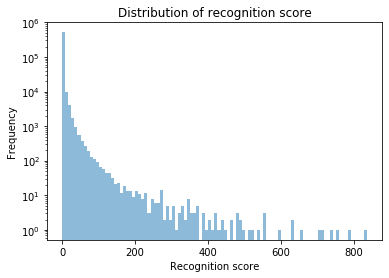

In [28]:
fig, ax = plt.subplots()
recognized_movies.recognition.plot.hist(ax=ax, bins=100, alpha=0.5)
ax.set_yscale('log')
ax.set_title('Distribution of recognition score')
ax.set_xlabel('Recognition score');

### Popularity  

We directly use the number of votes form the imdb website, we got it from ratings file from imdb

In [29]:
recognized_movies = recognized_movies.merge(movie_ratings, on='tconst', how='left')

### Revenue

We only use the revenue expressed in US dollars (the majority) as it is hard to find conversion rates before 2000. We use the easymoney library to take into account the inflation.

In [30]:
recognized_movies['worldwideGross_adjusted'] = recognized_movies['worldwideGross'].apply(keep_numbers)
ep = EasyPeasy()
recognized_movies['worldwideGross_adjusted'] = normalize_inflation(recognized_movies['worldwideGross_adjusted'],\
                                                                   recognized_movies['Year'])

## Comparing the three success metrics with the median age of the cast 

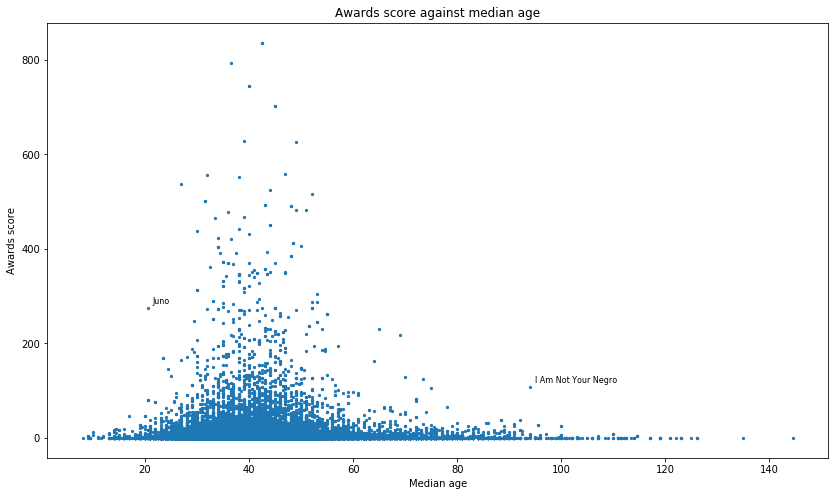

In [31]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['credible_median'],\
            recognized_movies['recognition'], s=5);
plt.title("Awards score against median age") 

annotations = []
annotations.append(recognized_movies[(recognized_movies['credible_median'] < 25) &\
                  (recognized_movies['recognition'] > 200)]\
                 [['primaryTitle', 'credible_median', 'recognition']].values[0])
annotations.append(recognized_movies[(recognized_movies['credible_median'] > 90) &\
                  (recognized_movies['recognition'] > 100)]\
                 [['primaryTitle', 'credible_median', 'recognition']].values[0])

for title, x, y in annotations:
    plt.text(x+1, y+10, title, fontsize=8)

#plt.yscale('symlog')
plt.xlabel('Median age')
plt.ylabel('Awards score');

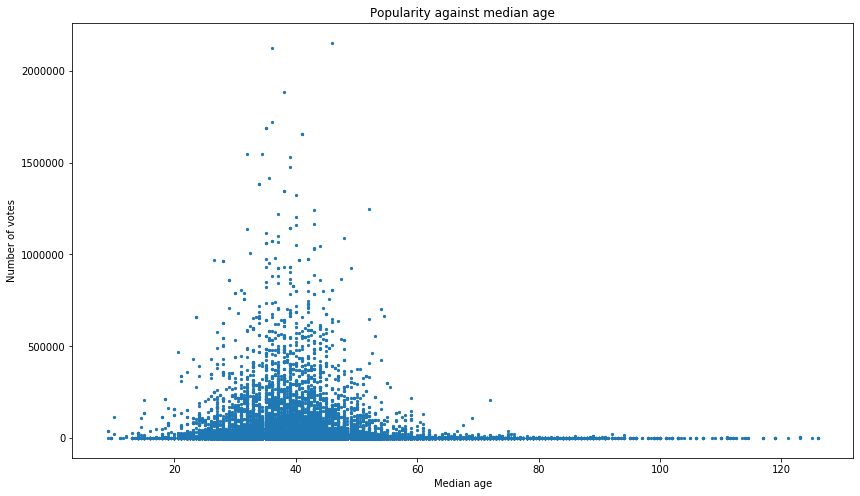

In [32]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['credible_median'],\
            recognized_movies['numVotes'], s=5);

plt.title("Popularity against median age")  
#plt.yscale('symlog')
plt.xlabel('Median age')
plt.ylabel('Number of votes');

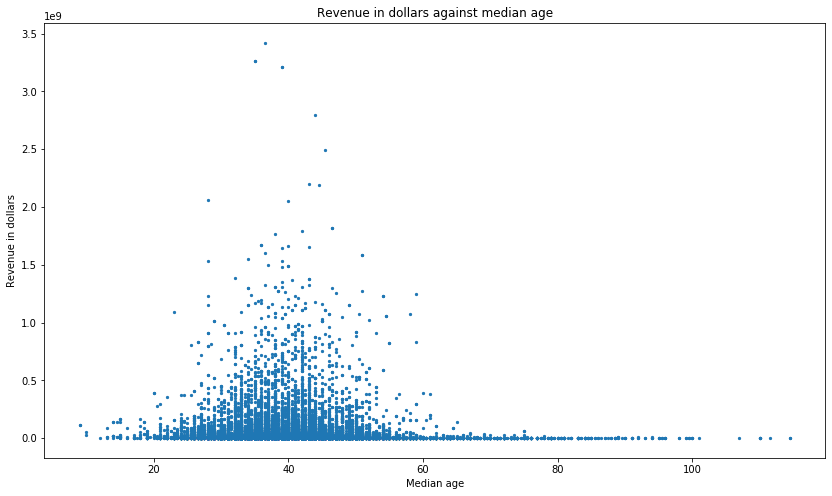

In [33]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['credible_median'],\
            recognized_movies['worldwideGross_adjusted'], s=5);

plt.title("Revenue in dollars against median age")
#plt.yscale('symlog')
plt.xlabel('Median age')
plt.ylabel('Revenue in dollars');

# Trying to go more in-depth with more statistics for some age intervals

In [34]:
intervals = np.arange(20, 90, 10)
intervals = np.insert(intervals, 0, 0)
intervals = np.insert(intervals, len(intervals), 150)
movies_stats = recognized_movies.groupby(pd.cut(recognized_movies['credible_median'], intervals))\
               ['recognition', 'numVotes', 'worldwideGross_adjusted']\
                 .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: bootstrap_mean_ci(x, 5, 1000), lambda x: bootstrap_median_ci(x, 5, 1000),\
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

movies_stats = movies_stats.rename(columns={'<lambda_0>': '95% CI mean', '<lambda_1>': '95% CI median',\
                                '<lambda_2>': '75%','<lambda_3>': '90%', '<lambda_4>': '95%','<lambda_5>': '99%'})

In [35]:
movies_stats['recognition']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
credible_median,,,,,,,,,,,,
"(0, 20]",248,3.076613,7.154044,0,47,0,"[2.367, 3.827]","[0.0, 0.0]",3,9,17.00,37.54
"(20, 30]",7488,3.264824,15.213295,0,538,0,"[2.974, 3.567]","[0.0, 0.0]",0,8,16.65,51.00
"(30, 40]",47526,3.490489,18.398615,0,794,0,"[3.345, 3.635]","[0.0, 0.0]",0,8,16.00,59.00
"(40, 50]",49064,3.274927,18.096975,0,836,0,"[3.147, 3.411]","[0.0, 0.0]",0,6,15.00,60.00
"(50, 60]",8437,3.637075,17.053491,0,517,0,"[3.34, 3.959]","[0.0, 0.0]",0,8,17.00,66.00
"(60, 70]",1438,3.376912,12.990862,0,230,0,"[2.818, 3.942]","[0.0, 0.0]",0,9,17.00,56.26
"(70, 80]",711,3.326301,10.140999,0,125,0,"[2.723, 3.989]","[0.0, 0.0]",2,10,16.50,45.00
"(80, 150]",427,2.915691,8.218404,0,108,0,"[2.314, 3.651]","[0.0, 0.0]",2,10,17.70,31.74


In [36]:
movies_stats['numVotes']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
credible_median,,,,,,,,,,,,
"(0, 20]",233.0,14598.343348,38146.476922,7.0,214105.0,519.0,"[10420.413, 18760.543]","[349.0, 634.0]",4579.0,40406.0,115313.40,191038.96
"(20, 30]",6776.0,10972.907320,51682.137452,5.0,971031.0,226.0,"[9951.286, 12088.116]","[214.0, 246.0]",1978.0,16366.5,46546.25,229226.50
"(30, 40]",42785.0,11070.220381,61724.174596,5.0,2126738.0,174.0,"[10584.418, 11561.048]","[170.0, 179.0]",1218.0,10472.0,43407.40,250970.92
"(40, 50]",44687.0,6999.394320,44176.815964,5.0,2153889.0,137.0,"[6661.15, 7376.689]","[134.0, 141.0]",837.0,5839.0,21045.00,165032.38
"(50, 60]",7732.0,4087.909079,28617.139238,5.0,1245991.0,157.0,"[3544.042, 4629.855]","[147.0, 166.525]",801.0,4175.0,10696.45,94412.62
"(60, 70]",1263.0,1620.030087,7409.416641,5.0,132869.0,111.0,"[1297.888, 1982.797]","[101.0, 128.0]",546.0,2481.0,6373.00,26237.36
"(70, 80]",634.0,1264.307571,8707.124702,5.0,207825.0,106.5,"[811.923, 1910.07]","[91.0, 131.5]",515.0,1838.3,5079.35,18208.00
"(80, 150]",380.0,621.192105,1872.794914,5.0,21967.0,99.0,"[478.483, 781.068]","[76.0, 119.0]",470.0,1427.7,2557.00,10881.59


In [37]:
movies_stats['worldwideGross_adjusted']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
credible_median,,,,,,,,,,,,
"(0, 20]",91.0,4.032998e+07,7.000282e+07,33102.56,3.881341e+08,1.221432e+07,"[29353809.627, 52071053.956]","[9039862.91, 15961159.98]",3.533039e+07,1.353178e+08,1.541172e+08,3.881341e+08
"(20, 30]",1956.0,4.027418e+07,1.180451e+08,483.39,2.063267e+09,4.576286e+06,"[35581010.057, 44858769.86]","[4008253.03, 5062429.706]",3.379935e+07,9.271842e+07,1.665044e+08,5.450699e+08
"(30, 40]",10609.0,5.403748e+07,1.579645e+08,0.00,3.421994e+09,4.217037e+06,"[51428665.837, 56572283.229]","[3967585.478, 4471612.77]",3.371477e+07,1.411023e+08,2.769024e+08,7.324322e+08
"(40, 50]",9292.0,4.531767e+07,1.392894e+08,37.32,2.797801e+09,3.271393e+06,"[43008622.641, 47592398.904]","[3071765.323, 3497784.919]",2.321982e+07,1.095509e+08,2.297256e+08,7.440602e+08
"(50, 60]",1894.0,2.935710e+07,1.208058e+08,99.39,1.583122e+09,1.667528e+06,"[24861449.317, 33942644.863]","[1472209.51, 1846747.02]",9.167173e+06,4.369420e+07,1.126804e+08,5.897151e+08
"(60, 70]",381.0,6.575293e+06,2.961579e+07,607.96,3.787216e+08,2.363985e+05,"[4380949.091, 9301989.839]","[180705.77, 331320.23]",1.173752e+06,8.608385e+06,2.197141e+07,1.572534e+08
"(70, 80]",214.0,1.708463e+06,7.154872e+06,35.12,6.509734e+07,1.353597e+05,"[954871.119, 2653991.234]","[84802.9, 191487.56]",5.569895e+05,2.159030e+06,5.193727e+06,2.936966e+07
"(80, 150]",113.0,7.500236e+05,1.981400e+06,382.91,1.211930e+07,1.131150e+05,"[473086.71, 1080958.358]","[71787.66, 187364.245]",5.148790e+05,1.084341e+06,3.557522e+06,1.171273e+07


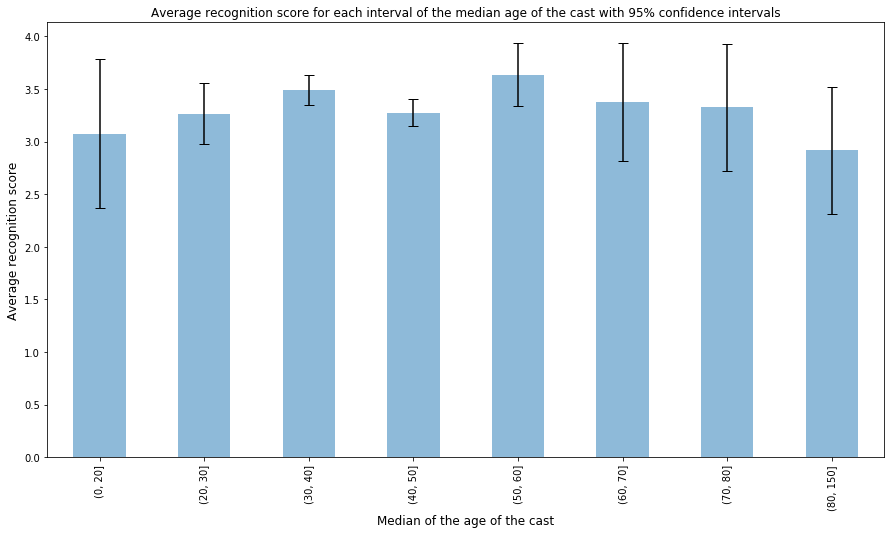

In [38]:
movies_stats_rec = movies_stats['recognition']
movies_stats_rec['errlo']  = movies_stats_rec['nanmean'] - movies_stats_rec['95% CI mean'].apply(lambda x: x[0])

movies_stats_rec['errhi']  = movies_stats_rec['95% CI mean'].apply(lambda x: x[1]) - movies_stats_rec['nanmean']

movies_stats_rec.plot(kind='bar', y='nanmean', yerr=movies_stats_rec[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Median of the age of the cast", size='large')
plt.ylabel("Average recognition score", size="large")
plt.title("Average recognition score for each interval of the median age of the cast with 95% confidence" +\
          " intervals" , size="large");

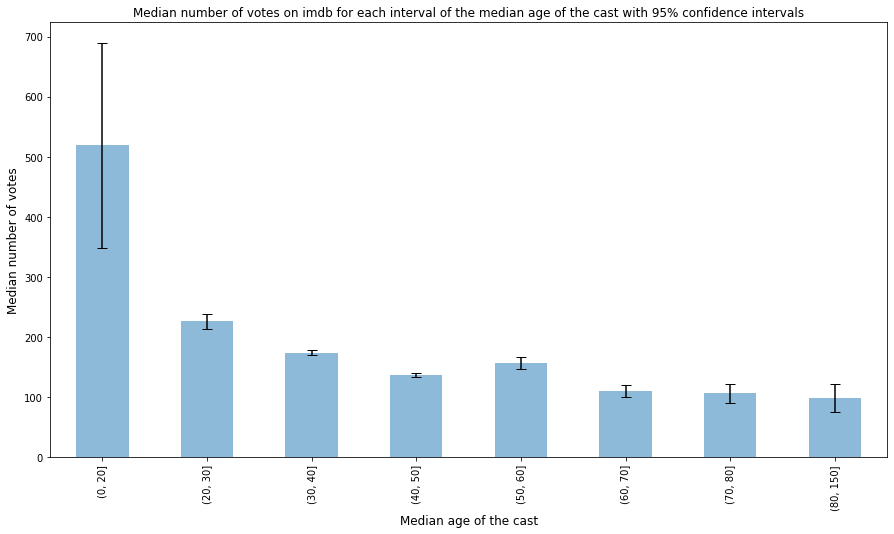

In [39]:
movies_stats_vot = movies_stats['numVotes']
movies_stats_vot['errlo']  = movies_stats_vot['nanmedian'] - movies_stats_vot['95% CI median'].apply(lambda x: x[0])

movies_stats_vot['errhi']  = movies_stats_vot['95% CI median'].apply(lambda x: x[1]) - movies_stats_vot['nanmedian']

movies_stats_vot.plot(kind='bar', y='nanmedian', yerr=movies_stats_vot[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Median age of the cast", size='large')
plt.ylabel("Median number of votes", size="large")
plt.title("Median number of votes on imdb for each interval of the median age of the" \
          " cast with 95% confidence intervals", size="large");

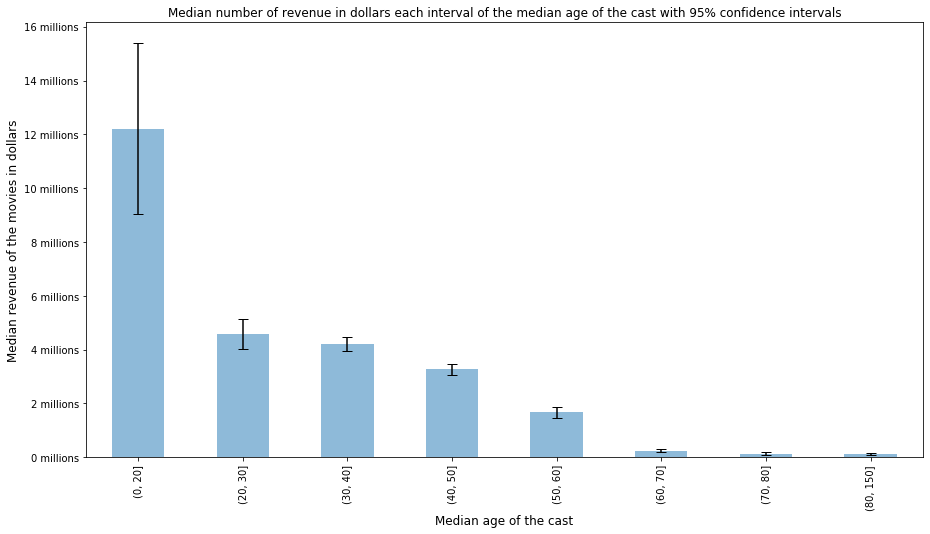

In [40]:
movies_stats_wor = movies_stats['worldwideGross_adjusted']
movies_stats_wor['errlo']  = movies_stats_wor['nanmedian'] - \
                             movies_stats_wor['95% CI median'].apply(lambda x: x[0])

movies_stats_wor['errhi']  = movies_stats_wor['95% CI median'].apply(lambda x: x[1]) - \
                             movies_stats_wor['nanmedian']

g = movies_stats_wor.plot(kind='bar', y='nanmedian', yerr=movies_stats_wor[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Median age of the cast", size='large')
plt.ylabel("Median revenue of the movies in dollars", size="large")
plt.title("Median number of revenue in dollars each interval of the median age of the cast with 95%" + \
          " confidence intervals", size="large");

ylabels = ['{:,.0f}'.format(x) + ' millions' for x in g.get_yticks()/1000000]
g.set_yticklabels(ylabels);

# Metacritic score

In [41]:
clean_metascore = [lambda x: np.nan if x == None else int(x)]
recognized_movies['metascore'] = recognized_movies['metascore'].apply(clean_metascore)

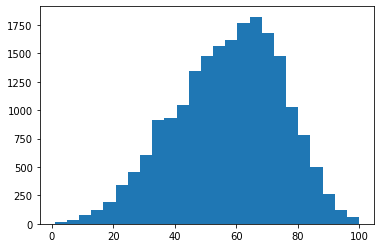

In [42]:
plt.hist(recognized_movies['metascore'], bins = 25);

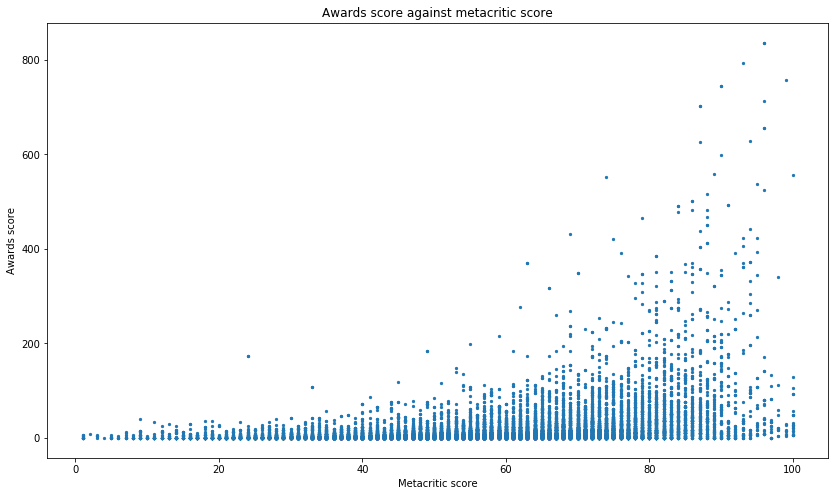

In [43]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['metascore'],\
            recognized_movies['recognition'], s=5);
plt.title("Awards score against metacritic score")   
#plt.yscale('symlog')
plt.xlabel('Metacritic score')
plt.ylabel('Awards score');

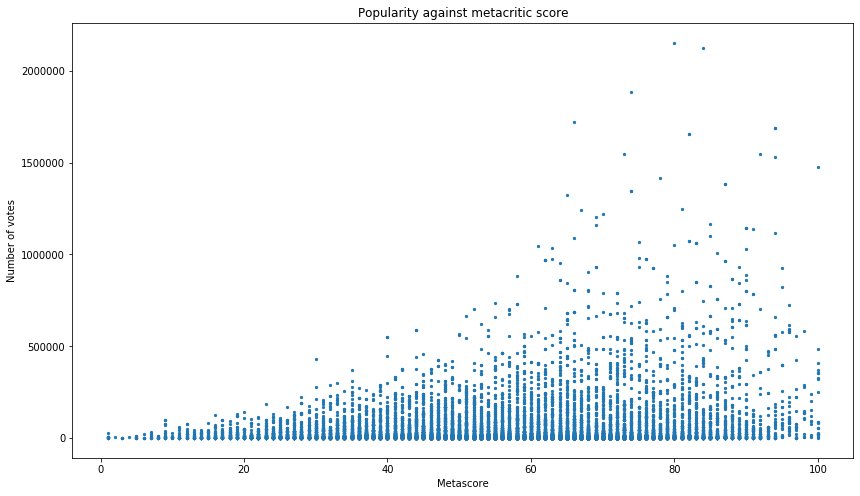

In [44]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['metascore'],\
            recognized_movies['numVotes'], s=5);

plt.title("Popularity against metacritic score")  
#plt.yscale('symlog')
plt.xlabel('Metascore')
plt.ylabel('Number of votes');

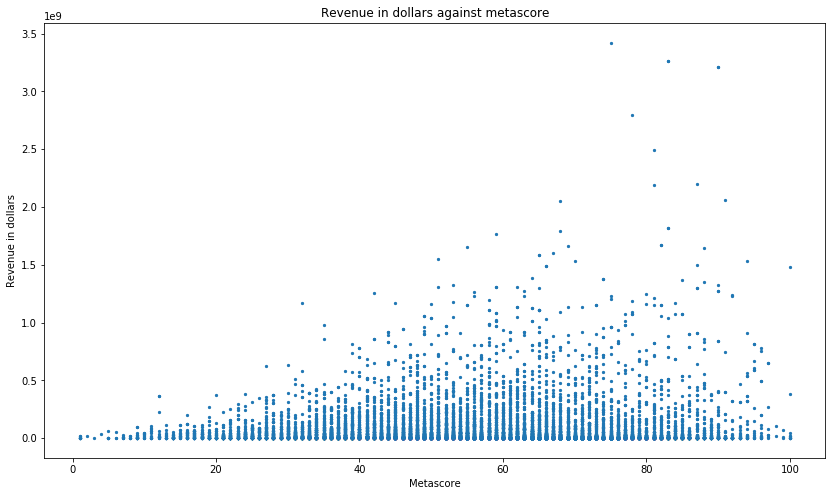

In [45]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['metascore'],\
            recognized_movies['worldwideGross_adjusted'], s=5);

plt.title("Revenue in dollars against metascore")
#plt.yscale('symlog')
plt.xlabel('Metascore')
plt.ylabel('Revenue in dollars');

# isAdult

In [46]:
recognized_movies.groupby('isAdult')['recognition', 'numVotes', 'worldwideGross_adjusted']\
                 .agg([cast_count, np.nanmean, np.nanmedian])

recognition                       numVotes                         \
         cast_count   nanmean nanmedian cast_count      nanmean nanmedian   
isAdult                                                                     
0.0          596696  1.333518         0   307397.0  3278.444149      48.0   
1.0            9886  0.143739         0     5205.0    39.898367      15.0   

        worldwideGross_adjusted                            
                     cast_count       nanmean   nanmedian  
isAdult                                                    
0.0                     55326.0  2.233228e+07  528639.015  
1.0                        10.0  7.771885e+04   43089.960

# runtimeMinutes

In [47]:
length_success = recognized_movies[['tconst', 'primaryTitle', 'runtimeMinutes', 'recognition', \
                                    'numVotes', 'worldwideGross_adjusted']]

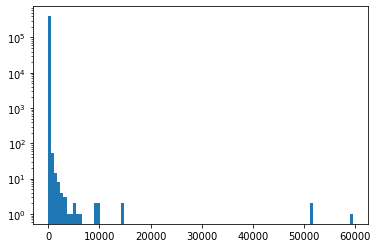

In [48]:
plt.hist(length_success['runtimeMinutes'], bins = 100);
plt.yscale('log', nonposy='clip')

In [49]:
length_success.nlargest(10, 'runtimeMinutes')[['tconst','primaryTitle', 'runtimeMinutes']]

,tconst,primaryTitle,runtimeMinutes
399886,tt10844584,100,59460.0
100142,tt8273150,Logistics,51420.0
100143,tt8273150,Logistics,51420.0
377635,tt2659636,Modern Times Forever,14400.0
377636,tt2659636,Modern Times Forever,14400.0
399880,tt10844900,Qw,10062.0
399881,tt10844900,Qw,10062.0
339117,tt2355497,Beijing 2003,9000.0
339118,tt2355497,Beijing 2003,9000.0
106922,tt5068890,Hunger!,6000.0


Even if the values are legit, we focus on the more conventional lengths

In [50]:
length_success = length_success[length_success['runtimeMinutes'] < 250]

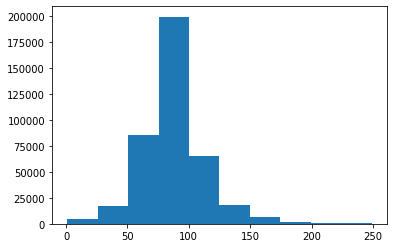

In [51]:
plt.hist(length_success['runtimeMinutes']);
#plt.yscale('log', nonposy='clip')

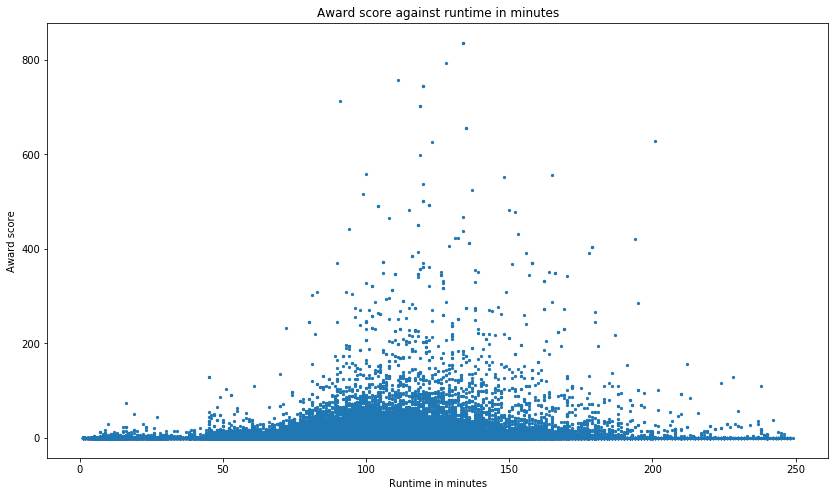

In [52]:
fig = plt.figure(figsize=(14,8))

plt.scatter(length_success['runtimeMinutes'],\
            length_success['recognition'], s=5);

plt.title("Award score against runtime in minutes")
#plt.yscale('symlog')
plt.xlabel('Runtime in minutes')
plt.ylabel('Award score');

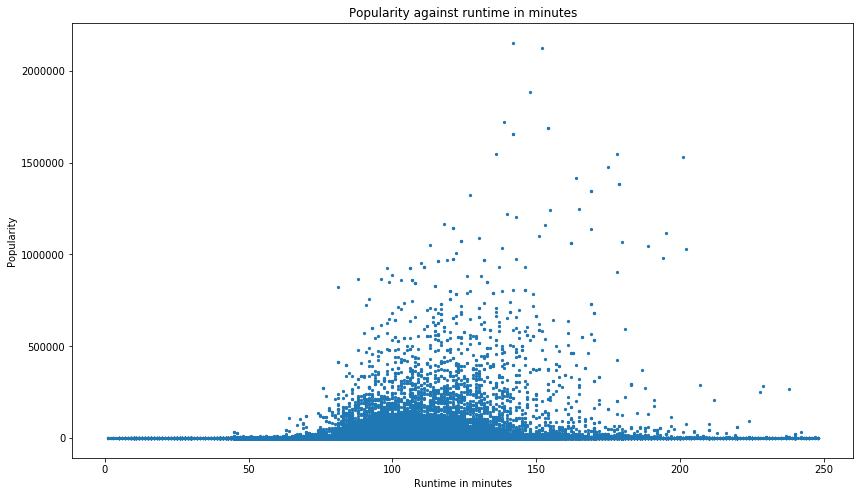

In [53]:
fig = plt.figure(figsize=(14,8))

plt.scatter(length_success['runtimeMinutes'],\
            length_success['numVotes'], s=5);

plt.title("Popularity against runtime in minutes")
#plt.yscale('symlog')
plt.xlabel('Runtime in minutes')
plt.ylabel('Popularity');

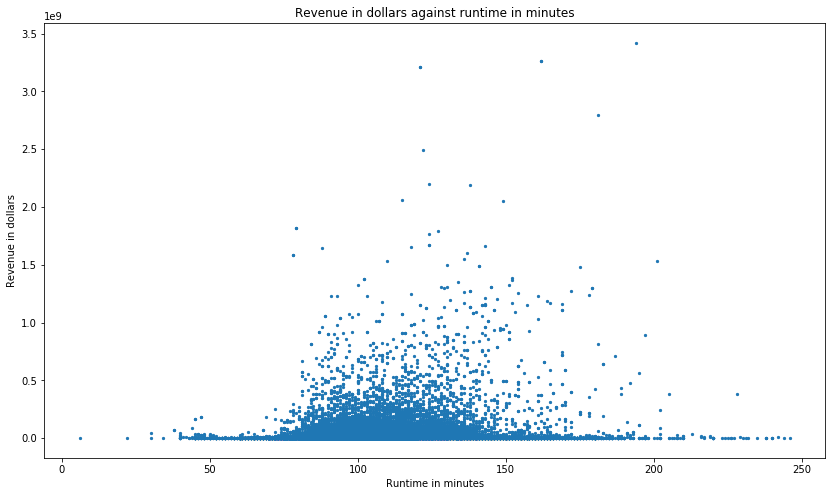

In [123]:
fig = plt.figure(figsize=(14,8))

plt.scatter(length_success['runtimeMinutes'],\
            length_success['worldwideGross_adjusted'], s=5);

plt.title("Revenue in dollars against runtime in minutes")
#plt.yscale('symlog')
plt.xlabel('Runtime in minutes')
plt.ylabel('Revenue in dollars');

# Trying to go more in-depth with more statistics for some runTime intervals

In [55]:
intervals = np.arange(50, 225, 25)
intervals = np.insert(intervals, 0, 0)
intervals = np.insert(intervals, len(intervals), 250)
movies_stats_runtime = recognized_movies.groupby(pd.cut(recognized_movies['runtimeMinutes'], intervals))\
               ['recognition', 'numVotes', 'worldwideGross_adjusted']\
                 .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: bootstrap_mean_ci(x, 5, 1000), lambda x: bootstrap_median_ci(x, 5, 1000),\
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

movies_stats_runtime = movies_stats_runtime.rename(columns={'<lambda_0>': '95% CI mean', \
'<lambda_1>': '95% CI median', '<lambda_2>': '75%','<lambda_3>': '90%', '<lambda_4>': '95%','<lambda_5>': '99%'})

In [56]:
movies_stats_runtime['recognition']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
runtimeMinutes,,,,,,,,,,,,
"(0, 50]",22105,0.214703,2.347185,0,130,0,"[0.189, 0.241]","[0.0, 0.0]",0,0,0.0,6.00
"(50, 75]",85078,0.331249,2.380787,0,232,0,"[0.317, 0.346]","[0.0, 0.0]",0,0,0.0,9.00
"(75, 100]",199427,1.497149,6.988321,0,713,0,"[1.472, 1.523]","[0.0, 0.0]",0,4,9.0,26.00
"(100, 125]",66825,4.367467,17.748371,0,757,0,"[4.26, 4.474]","[0.0, 0.0]",2,12,22.0,61.00
"(125, 150]",17929,5.739919,26.206637,0,836,0,"[5.425, 6.079]","[0.0, 0.0]",0,13,28.0,100.00
"(150, 175]",5854,5.779467,27.200348,0,556,0,"[5.187, 6.361]","[0.0, 0.0]",0,11,24.0,110.00
"(175, 200]",1544,6.511658,28.735996,0,420,0,"[5.364, 7.814]","[0.0, 0.0]",0,14,31.0,105.99
"(200, 250]",747,4.200803,26.597584,0,628,0,"[2.862, 5.985]","[0.0, 0.0]",0,6,21.4,89.32


In [57]:
movies_stats_runtime['numVotes']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
runtimeMinutes,,,,,,,,,,,,
"(0, 50]",5209.0,97.870417,966.812784,5.0,34937.0,14.0,"[77.689, 120.569]","[13.0, 14.0]",31.00,95.0,209.0,1148.36
"(50, 75]",41842.0,184.897519,2034.536479,5.0,134792.0,22.0,"[169.291, 202.599]","[22.0, 22.0]",67.00,213.0,472.0,2205.00
"(75, 100]",152834.0,1831.488694,15153.738001,5.0,928857.0,63.0,"[1767.871, 1894.345]","[62.0, 63.0]",292.00,1350.0,3856.0,38286.23
"(100, 125]",54797.0,7956.857729,44200.350275,5.0,1166368.0,153.0,"[7650.888, 8265.159]","[149.0, 156.0]",972.00,7266.0,28104.2,191947.40
"(125, 150]",14128.0,13967.815898,77278.926779,5.0,2153889.0,136.0,"[12925.577, 15067.578]","[129.0, 142.0]",1080.00,9352.5,48042.0,375064.00
"(150, 175]",4876.0,12957.367104,90911.226354,5.0,2126738.0,164.0,"[10928.711, 15179.677]","[151.975, 179.0]",1093.00,6559.0,20947.5,376742.00
"(175, 200]",1164.0,14479.926976,104186.618009,5.0,1545029.0,111.5,"[9662.578, 19647.532]","[91.0, 132.0]",1100.75,9003.2,29286.7,297046.00
"(200, 250]",539.0,9029.018553,83350.722170,5.0,1529752.0,62.0,"[3992.363, 14845.437]","[54.975, 70.5]",331.00,3106.0,8512.3,231953.58


In [58]:
movies_stats_runtime['worldwideGross_adjusted']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
runtimeMinutes,,,,,,,,,,,,
"(0, 50]",112.0,1.474727e+07,3.390249e+07,615.48,1.791959e+08,670241.185,"[9696237.718, 20429106.005]","[199187.34, 1856939.67]",1.632282e+07,3.308944e+07,6.886404e+07,1.771724e+08
"(50, 75]",1579.0,2.320398e+06,1.294966e+07,15.69,2.543084e+08,33190.470,"[1816521.092, 2846553.503]","[28462.03, 39583.35]",5.050440e+05,3.327863e+06,6.722089e+06,5.091327e+07
"(75, 100]",26000.0,1.281151e+07,6.148520e+07,13.77,1.814742e+09,324282.010,"[12202178.615, 13470689.637]","[312069.777, 338091.537]",2.755526e+06,1.974084e+07,5.585787e+07,2.596821e+08
"(100, 125]",17372.0,3.121952e+07,1.063394e+08,0.00,3.213030e+09,1752497.565,"[29937631.457, 32612686.867]","[1675813.7, 1829299.14]",1.369850e+07,7.426208e+07,1.665387e+08,4.938258e+08
"(125, 150]",4041.0,6.455426e+07,1.875108e+08,30.72,2.191172e+09,2346579.520,"[60124370.482, 69511692.837]","[2037845.77, 2701922.146]",2.638386e+07,1.703832e+08,3.737019e+08,1.030798e+09
"(150, 175]",1035.0,6.381000e+07,2.360697e+08,43.03,3.265544e+09,754777.550,"[50751616.967, 76631865.519]","[621668.77, 926320.659]",9.076590e+06,1.273384e+08,3.764803e+08,1.171720e+09
"(175, 200]",237.0,7.900650e+07,3.390729e+08,1494.28,3.421994e+09,1489766.620,"[46628314.707, 118348859.103]","[1158170.39, 1842441.585]",9.156066e+06,6.792898e+07,4.406243e+08,1.294937e+09
"(200, 250]",62.0,4.575845e+07,2.052190e+08,305.76,1.529402e+09,360553.840,"[12301882.224, 93158827.492]","[99545.23, 1071707.304]",6.083686e+06,3.065477e+07,2.366334e+08,8.282070e+08


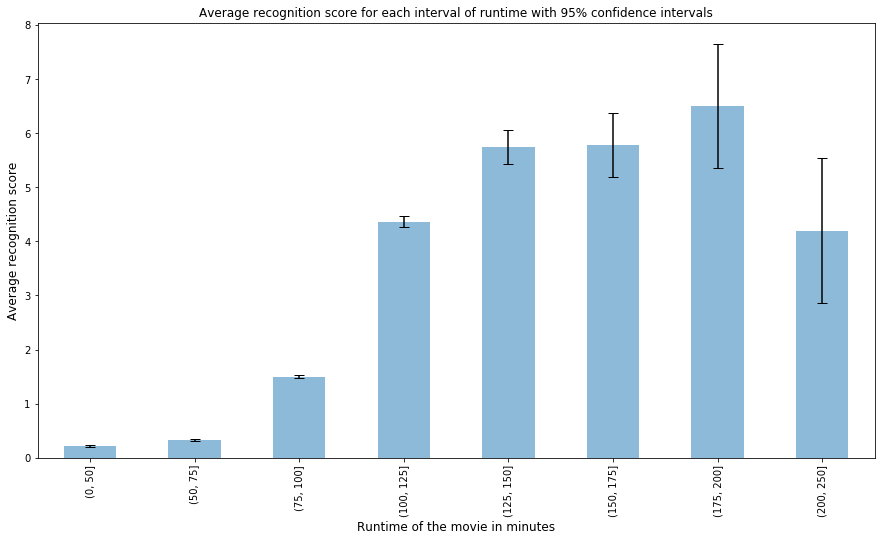

In [59]:
movies_stats_run_rec = movies_stats_runtime['recognition']
movies_stats_run_rec['errlo']  = movies_stats_run_rec['nanmean'] - \
                                 movies_stats_run_rec['95% CI mean'].apply(lambda x: x[0])

movies_stats_run_rec['errhi']  = movies_stats_run_rec['95% CI mean'].apply(lambda x: x[1]) -\
                                 movies_stats_run_rec['nanmean']

movies_stats_run_rec.plot(kind='bar', y='nanmean', yerr=movies_stats_run_rec[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Runtime of the movie in minutes", size='large')
plt.ylabel("Average recognition score", size="large")
plt.title("Average recognition score for each interval of runtime with 95% confidence" +\
          " intervals" , size="large");

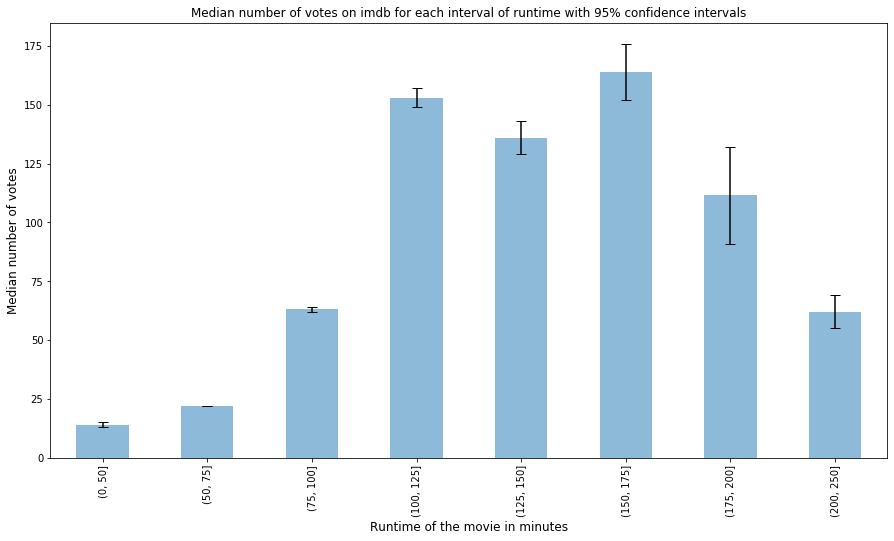

In [60]:
movies_stats_run_vot = movies_stats_runtime['numVotes']
movies_stats_run_vot['errlo']  = movies_stats_run_vot['nanmedian'] - \
                                 movies_stats_run_vot['95% CI median'].apply(lambda x: x[0])

movies_stats_run_vot['errhi']  = movies_stats_run_vot['95% CI median'].apply(lambda x: x[1]) -\
                                 movies_stats_run_vot['nanmedian']

movies_stats_run_vot.plot(kind='bar', y='nanmedian', yerr=movies_stats_run_vot[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Runtime of the movie in minutes", size='large')
plt.ylabel("Median number of votes", size="large")
plt.title("Median number of votes on imdb for each interval of runtime with 95% confidence" +\
          " intervals" , size="large");

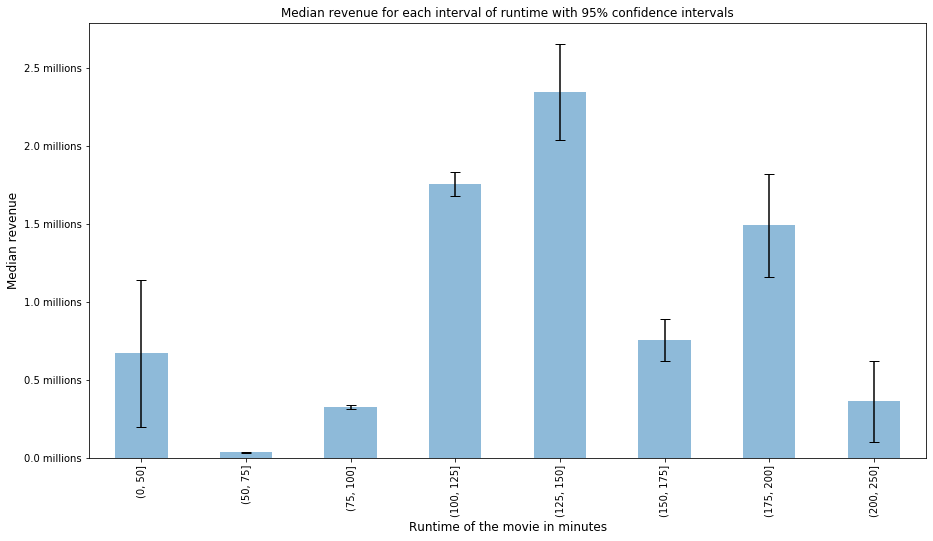

In [61]:
movies_stats_run_wor = movies_stats_runtime['worldwideGross_adjusted']
movies_stats_run_wor['errlo']  = movies_stats_run_wor['nanmedian'] - \
                                 movies_stats_run_wor['95% CI median'].apply(lambda x: x[0])

movies_stats_run_wor['errhi']  = movies_stats_run_wor['95% CI median'].apply(lambda x: x[1]) -\
                                 movies_stats_run_wor['nanmedian']

g = movies_stats_run_wor.plot(kind='bar', y='nanmedian', yerr=movies_stats_run_wor[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Runtime of the movie in minutes", size='large')
plt.ylabel("Median revenue", size="large")
plt.title("Median revenue for each interval of runtime with 95% confidence" +\
          " intervals" , size="large");
ylabels = ['{:,.1f}'.format(x) + ' millions' for x in g.get_yticks()/1000000]
g.set_yticklabels(ylabels);

# plotKeywords

Instead of doing statistics for each keywords, we get the top 1000 of movies in term of recognition, number of votes and revenue and compare the keywords of those movies with the other ones.

Because of the explicit nature of the adult movies plot keywords, we only take into account the family-friendly movies in this section.

In [62]:
top_recognition = recognized_movies.sort_values('recognition', ascending=False).head(1000)
top_numVotes = recognized_movies.sort_values('numVotes', ascending=False).head(1000)
top_revenue = recognized_movies.sort_values('worldwideGross_adjusted', ascending=False).head(1000)

In [63]:
top_reco_keywords = top_recognition.explode('plotKeywords').groupby('plotKeywords').agg([cast_count])['oscarWins']
top_numV_keywords = top_numVotes.explode('plotKeywords').groupby('plotKeywords').agg([cast_count])['oscarWins']
top_rev_keywords = top_revenue.explode('plotKeywords').groupby('plotKeywords').agg([cast_count])['oscarWins']

In [64]:
top_reco_keywords = top_reco_keywords[top_reco_keywords['cast_count'] > 10]
top_numV_keywords = top_numV_keywords[top_numV_keywords['cast_count'] > 10]
top_rev_keywords = top_rev_keywords[top_rev_keywords['cast_count'] > 10]

In [65]:
top_reco_keywords

,cast_count
plotKeywords,
1960s,17
1970s,18
adultery,15
anthropomorphism,12
bare breasts,19
...,...
violence,31
warrior,11
world war two,14


In [66]:
top_keywords = recognized_movies.explode('plotKeywords').groupby('plotKeywords')\
                       ['recognition', 'numVotes', 'worldwideGross_adjusted']\
                      .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

In [67]:
top_keywords['recognition'].sort_values('nanmean', ascending=False)

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,<lambda_0>,<lambda_1>,<lambda_2>,<lambda_3>
plotKeywords,,,,,,,,,,
listening to a car radio,1,794.0,NaN,794,794,794.0,794.0,794.0,794.0,794.0
bigger dreams,1,794.0,NaN,794,794,794.0,794.0,794.0,794.0,794.0
jazz club,1,794.0,NaN,794,794,794.0,794.0,794.0,794.0,794.0
meet cute,1,794.0,NaN,794,794,794.0,794.0,794.0,794.0,794.0
pipe dream,1,794.0,NaN,794,794,794.0,794.0,794.0,794.0,794.0
...,...,...,...,...,...,...,...,...,...,...
italian sex comedy,2,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
corps,1,0.0,NaN,0,0,0.0,0.0,0.0,0.0,0.0
schoolgirl crush,1,0.0,NaN,0,0,0.0,0.0,0.0,0.0,0.0


In [68]:
top_keywords2 = recognized_movies[recognized_movies['isAdult'] == 0.0]\
              .explode('plotKeywords').groupby('plotKeywords')\
                       ['recognition', 'numVotes', 'worldwideGross_adjusted']\
                      .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

In [69]:
top_keywords2 = top_keywords2[top_keywords2['recognition']['cast_count'] > 10]
top_keywords2 = top_keywords2['recognition'].sort_values('cast_count', ascending=False)

In [70]:
top_keywords2.head(20)

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,<lambda_0>,<lambda_1>,<lambda_2>,<lambda_3>
plotKeywords,,,,,,,,,,
female nudity,869,23.064442,70.061053,0,744,2.0,14.00,48.0,118.40,357.00
female frontal nudity,515,21.902913,55.703445,0,361,3.0,16.00,48.0,100.40,322.00
male frontal nudity,431,30.645012,87.796550,0,836,6.0,22.00,62.0,139.00,427.40
male nudity,331,31.978852,66.741402,0,599,9.0,32.00,79.0,151.50,356.20
female full frontal nudity,326,17.880368,54.591020,0,627,2.0,12.50,35.0,78.50,239.25
nudity,318,24.402516,75.792313,0,655,2.0,14.00,55.3,124.45,359.30
female rear nudity,304,28.118421,68.445197,0,627,3.5,20.25,79.0,144.00,322.00
bare breasts,290,23.913793,75.339023,0,627,2.0,13.00,40.0,126.55,364.63
pubic hair,271,22.476015,56.389702,0,627,2.0,18.00,77.0,106.00,252.00


# Frequency of each award

We try to define weights based on the frequency of each award

In [71]:
recognized_movies['oscarWins'].sum()

1433

In [72]:
recognized_movies['wins'].sum()

235457

In [73]:
recognized_movies['nominations'].sum()

312057

In [74]:
OSCAR_WEIGHT = recognized_movies['oscarWins'].sum() / recognized_movies['oscarWins'].sum()
WIN_WEIGHT = recognized_movies['oscarWins'].sum() / recognized_movies['wins'].sum()
NOMINATION_WEIGHT = recognized_movies['oscarWins'].sum() / recognized_movies['nominations'].sum()
recognized_movies['recognition2'] = (recognized_movies['oscarWins'] * OSCAR_WEIGHT) + \
                                    (recognized_movies['nominations'] * NOMINATION_WEIGHT)  + \
                                    (recognized_movies['wins'] * WIN_WEIGHT)

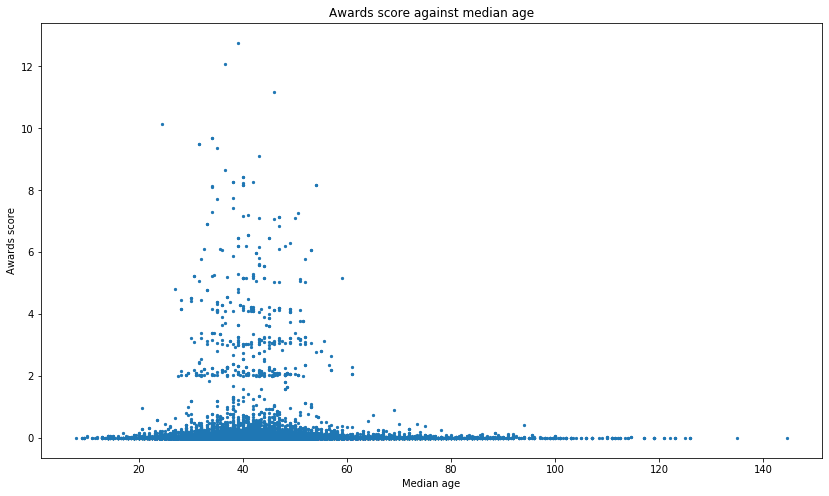

In [75]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['credible_median'],\
            recognized_movies['recognition2'], s=5);
plt.title("Awards score against median age") 


#plt.yscale('symlog')
plt.xlabel('Median age')
plt.ylabel('Awards score');

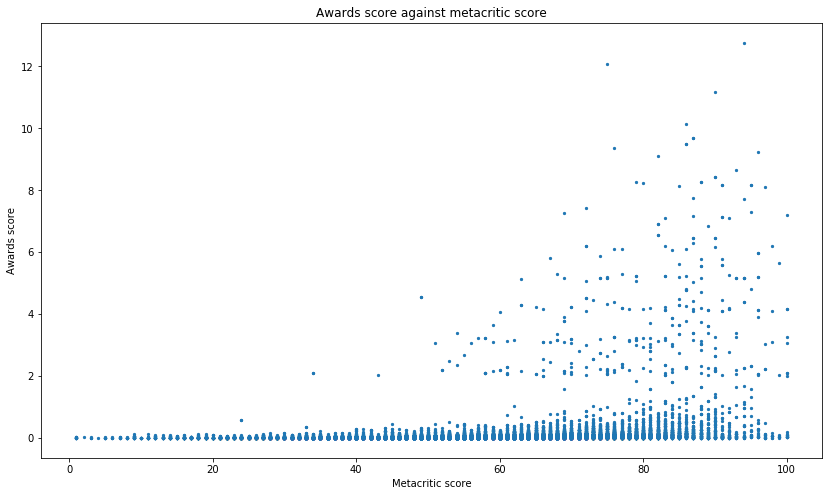

In [76]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['metascore'],\
            recognized_movies['recognition2'], s=5);
plt.title("Awards score against metacritic score")   
#plt.yscale('symlog')
plt.xlabel('Metacritic score')
plt.ylabel('Awards score');

In [77]:
intervals = np.arange(20, 90, 10)
intervals = np.insert(intervals, 0, 0)
intervals = np.insert(intervals, len(intervals), 150)
movies_stats2 = recognized_movies.groupby(pd.cut(recognized_movies['credible_median'], intervals))['recognition2']\
                 .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

movies_stats2 = movies_stats2.rename(columns={'<lambda_0>': '75%', '<lambda_1>': '90%', \
                                            '<lambda_2>': '95%','<lambda_3>': '99%'})

In [78]:
movies_stats2

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,75%,90%,95%,99%
credible_median,,,,,,,,,,
"(0, 20]",248.0,0.011305,0.025550,0.0,0.166258,0.0,0.012172,0.032034,0.064550,0.129540
"(20, 30]",7488.0,0.018964,0.198772,0.0,10.155470,0.0,0.000000,0.027553,0.060860,0.198513
"(30, 40]",47526.0,0.025048,0.278569,0.0,12.765273,0.0,0.000000,0.027553,0.059587,0.240604
"(40, 50]",49064.0,0.023919,0.243726,0.0,11.163160,0.0,0.000000,0.024344,0.055105,0.259705
"(50, 60]",8437.0,0.028289,0.278429,0.0,8.163160,0.0,0.000000,0.030541,0.062685,0.269474
"(60, 70]",1438.0,0.016375,0.108108,0.0,2.291739,0.0,0.000000,0.032068,0.061289,0.200715
"(70, 80]",711.0,0.012177,0.036859,0.0,0.434596,0.0,0.009184,0.036516,0.060279,0.166369
"(80, 150]",427.0,0.010661,0.030452,0.0,0.403002,0.0,0.009184,0.036604,0.061983,0.123378


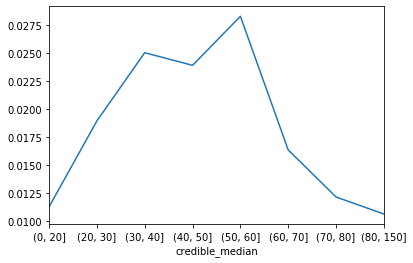

In [79]:
movies_stats2['nanmean'].plot()

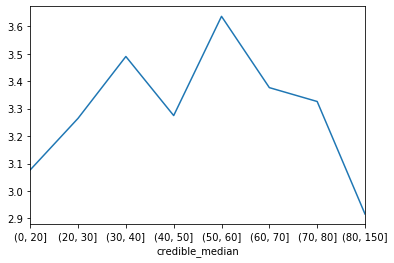

In [80]:
movies_stats['recognition']['nanmean'].plot()

In [81]:
intervals = np.arange(0, 250+25, 25)
movies_stats_runtime2 = recognized_movies.groupby(pd.cut(recognized_movies['runtimeMinutes'], intervals))\
                 ['recognition2']\
                 .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

movies_stats_runtime2 = movies_stats_runtime2.rename(columns={'<lambda_0>': '75%', '<lambda_1>': '90%', \
                                            '<lambda_2>': '95%','<lambda_3>': '99%'})

In [82]:
movies_stats_runtime2

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,75%,90%,95%,99%
runtimeMinutes,,,,,,,,,,
"(0, 25]",4808.0,0.000670,0.006422,0.0,0.245266,0.0,0.000000,0.000000,0.000000,0.018258
"(25, 50]",17297.0,0.000738,0.008239,0.0,0.445163,0.0,0.000000,0.000000,0.000000,0.018258
"(50, 75]",85078.0,0.001147,0.008218,0.0,0.860889,0.0,0.000000,0.000000,0.000000,0.030430
"(75, 100]",199427.0,0.006008,0.053139,0.0,9.230850,0.0,0.000000,0.013776,0.032034,0.094609
"(100, 125]",66825.0,0.024160,0.212699,0.0,9.480944,0.0,0.009184,0.042602,0.079339,0.234087
"(125, 150]",17929.0,0.041491,0.319185,0.0,8.648732,0.0,0.000000,0.048688,0.102410,0.566141
"(150, 175]",5854.0,0.057348,0.503186,0.0,10.155470,0.0,0.000000,0.038120,0.090128,0.704868
"(175, 200]",1544.0,0.098473,0.663949,0.0,12.067263,0.0,0.000000,0.048766,0.111467,3.575948
"(200, 225]",452.0,0.081724,0.852609,0.0,12.765273,0.0,0.000000,0.025650,0.075530,0.367180


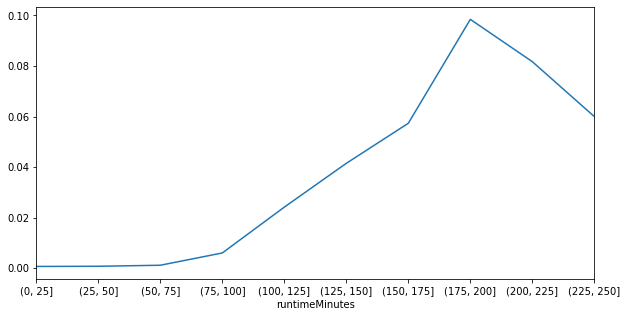

In [83]:
plt.figure(figsize=(10,5))
movies_stats_runtime2['nanmean'].plot();

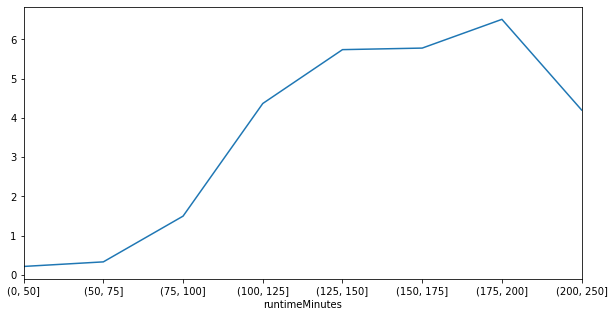

In [84]:
plt.figure(figsize=(10,5))
movies_stats_runtime['recognition']['nanmean'].plot();

# Correlation between the 3 success metrics

In [85]:
recognized_movies.corr()[['recognition', 'numVotes', 'worldwideGross_adjusted', 'averageRating', 'metascore']]

,recognition,numVotes,worldwideGross_adjusted,averageRating,metascore
oscarWins,0.431487,0.304884,0.300462,0.038065,0.154064
nominations,0.916927,0.537487,0.359989,0.097238,0.319802
wins,0.957375,0.448270,0.292322,0.121873,0.341582
metascore,0.347569,0.142388,0.053685,0.675437,1.000000
isAdult,-0.016302,-0.013654,-0.003025,-0.049930,-0.011594
startYear,0.087035,0.041723,-0.130094,0.035097,-0.108568
runtimeMinutes,0.020712,0.012714,0.150062,0.008551,0.149057
genres,NaN,NaN,NaN,NaN,NaN
testYear,0.089932,0.041444,-0.137217,0.014418,-0.096046
Year,0.086433,0.041711,-0.130332,0.035138,-0.108622


# Genres

In [86]:
movies_filtered = pd.read_pickle('pickles/filtered_movies.pkl')
movies_genres = movies_filtered[['tconst', 'genres']]
recognized_movies = recognized_movies.drop(['genres'], axis=1)
recognized_movies = recognized_movies.merge(movies_genres, on='tconst', how='left')
recognized_movies = recognized_movies.replace('\\N', np.nan)
recognized_movies['genres'] = recognized_movies['genres'].apply(split_profession)
recognized_movies

In [93]:
genres = recognized_movies.explode('genres').groupby('genres')['tconst']\
         .agg({'size': len, 'set': lambda x: set(x)})

In [94]:
genres

,size,set
genres,,
Action,53026,"{tt0211473, tt5289106, tt1974313, tt0017192, t..."
Adult,8984,"{tt0072899, tt0196538, tt0144403, tt0125282, t..."
Adventure,29053,"{tt1974313, tt3714818, tt11274100, tt0062528, ..."
Animation,7937,"{tt6464808, tt4219304, tt0356936, tt3565158, t..."
Biography,17408,"{tt3411802, tt3385524, tt0090798, tt3280478, t..."
Comedy,110859,"{tt8215312, tt1650407, tt3385524, tt0007783, t..."
Crime,36667,"{tt7358792, tt0211473, tt4614082, tt0098172, t..."
Documentary,110145,"{tt10300682, tt1619835, tt0137339, tt1722427, ..."
Drama,221689,"{tt0315431, tt3385524, tt0007783, tt1326799, t..."


We remove the small set such as Game-show, Short and Talk-show

In [95]:
genres = genres[genres['size'] > 100].reset_index()

In [96]:
jaccard = df_crossjoin(genres)

In [98]:
jaccard['distance'] = np.vectorize(jaccard_similarity)(jaccard['set_x'], jaccard['set_y'])
jaccard = jaccard.drop(['set_x', 'set_y'], axis=1)

In [99]:
jaccard

,genres_x,size_x,genres_y,size_y,distance
0,Action,53026,Action,53026,1.00
1,Action,53026,Adult,8984,0.00
2,Action,53026,Adventure,29053,0.13
3,Action,53026,Animation,7937,0.02
4,Action,53026,Biography,17408,0.01
...,...,...,...,...,...
620,Western,8033,Sci-Fi,12758,0.00
621,Western,8033,Sport,6745,0.00
622,Western,8033,Thriller,40408,0.00
623,Western,8033,War,9886,0.00


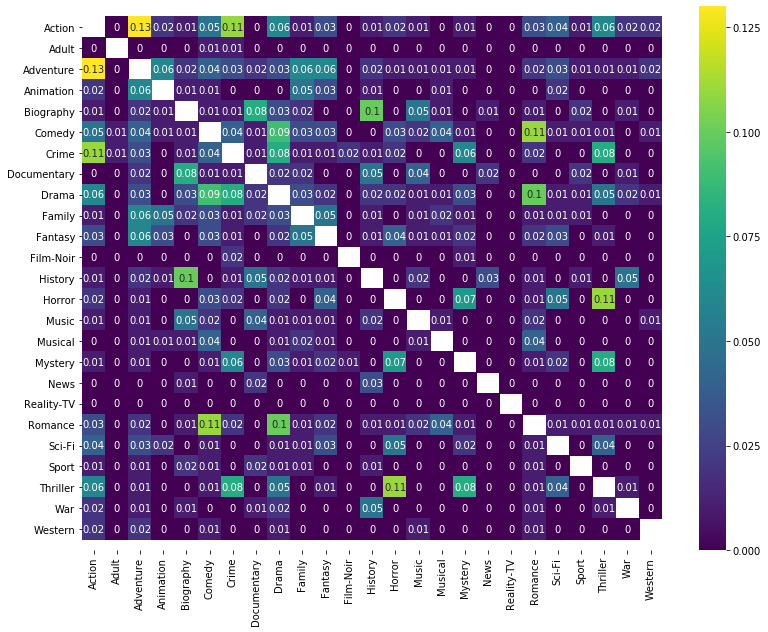

In [101]:
jaccard_pivot = jaccard.pivot(index='genres_x', columns='genres_y', values='distance')
plt.figure(figsize=(13,10))

mask = np.zeros((len(jaccard_pivot), len(jaccard_pivot)))
mask[np.diag_indices(len(jaccard_pivot))] = True

ax = sns.heatmap(jaccard_pivot, mask=mask, fmt="g", cmap='viridis', vmax = 0.13, annot=True)
ax.set_ylim(len(jaccard_pivot)+0.5, -0.5);
ax.set_xlabel('');
ax.set_ylabel('');

In [102]:
genres_success = recognized_movies.explode('genres').groupby('genres')['recognition', 'numVotes',\
                                                                       'worldwideGross_adjusted']\
                 .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: bootstrap_mean_ci(x, 5, 1000), lambda x: bootstrap_median_ci(x, 5, 1000),\
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

genres_success = genres_success.rename(columns={'<lambda_0>': '95% CI mean', '<lambda_1>': '95% CI median',\
                                '<lambda_2>': '75%','<lambda_3>': '90%', '<lambda_4>': '95%','<lambda_5>': '99%'})

In [107]:
genres_success['recognition']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
genres,,,,,,,,,,,,
Action,53026,1.531683,11.344105,0,744,0,"[1.452, 1.623]","[0.0, 0.0]",0,0,6.0,33.00
Adult,8984,0.142698,1.237700,0,29,0,"[0.122, 0.165]","[0.0, 0.0]",0,0,0.0,5.00
Adventure,29053,2.390975,17.038265,0,744,0,"[2.22, 2.546]","[0.0, 0.0]",0,3,10.0,54.00
Animation,7937,2.590525,14.389497,0,305,0,"[2.335, 2.861]","[0.0, 0.0]",0,4,11.0,60.00
Biography,17408,3.896140,21.142746,0,836,0,"[3.631, 4.153]","[0.0, 0.0]",0,7,18.0,77.00
Comedy,110859,1.583128,9.329059,0,794,0,"[1.538, 1.633]","[0.0, 0.0]",0,3,8.0,30.00
Crime,36667,2.320452,12.932403,0,517,0,"[2.213, 2.437]","[0.0, 0.0]",0,4,12.0,43.00
Documentary,110145,0.645122,3.609644,0,159,0,"[0.626, 0.663]","[0.0, 0.0]",0,0,4.0,14.00
Drama,221689,2.551980,13.536713,0,836,0,"[2.506, 2.606]","[0.0, 0.0]",0,6,14.0,42.00


In [105]:
genres_success['numVotes']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
genres,,,,,,,,,,,,
Action,33509.0,9319.874332,56344.337445,5.0,2126738.0,88.0,"[8848.87, 9838.267]","[86.0, 92.0]",652.00,5166.2,26715.20,241941.00
Adult,4903.0,51.370589,656.053016,5.0,31787.0,15.0,"[37.75, 69.079]","[14.0, 15.0]",32.00,67.0,116.00,372.74
Adventure,20744.0,12391.640474,70568.144910,5.0,1887822.0,72.0,"[11574.026, 13221.269]","[70.0, 74.0]",583.25,6001.1,44798.95,336303.00
Animation,5074.0,11109.116082,55255.096669,5.0,928857.0,122.0,"[9932.318, 12351.868]","[115.0, 133.0]",923.75,9154.7,46448.00,254215.82
Biography,9289.0,7033.479061,43369.607805,5.0,1117135.0,73.0,"[6300.05, 7830.927]","[68.0, 78.0]",734.00,5960.0,24536.00,156229.00
Comedy,79505.0,3733.931174,25363.977326,5.0,978083.0,85.0,"[3581.663, 3878.559]","[83.0, 86.0]",461.00,2748.6,9709.00,87428.80
Crime,26531.0,6809.084693,45468.654624,5.0,2126738.0,117.0,"[6415.069, 7253.591]","[113.0, 121.0]",825.50,6413.0,22386.00,143911.00
Documentary,43084.0,284.093794,2364.746198,5.0,135933.0,21.0,"[265.871, 304.776]","[20.0, 21.0]",70.00,287.0,737.00,4946.01
Drama,138559.0,3596.019068,32530.337644,5.0,2153889.0,65.0,"[3455.739, 3739.875]","[65.0, 66.0]",356.00,2226.0,7482.10,75246.52


In [106]:
genres_success['worldwideGross_adjusted']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
genres,,,,,,,,,,,,
Action,6697.0,6.881855e+07,1.938822e+08,33.24,3.265544e+09,3924602.210,"[65197084.074, 72581333.235]","[3615381.42, 4352798.45]",3.783660e+07,1.932511e+08,3.860046e+08,9.174519e+08
Adult,7.0,4.268632e+04,5.261775e+04,1266.54,1.186690e+05,17029.180,"[10886.735, 76229.88]","[1266.54, 118669.01]",7.177188e+04,1.186690e+05,1.186690e+05,1.186690e+05
Adventure,4172.0,1.144442e+08,2.692355e+08,118.66,3.265544e+09,8269432.920,"[107456190.69, 120828701.04]","[7491819.081, 9293815.31]",8.040450e+07,3.615290e+08,6.850899e+08,1.231196e+09
Animation,2199.0,6.497155e+07,1.890933e+08,127.28,1.814742e+09,3178339.530,"[58824004.324, 71492875.278]","[2848310.51, 3661061.484]",2.129107e+07,1.712856e+08,4.093269e+08,9.755054e+08
Biography,2658.0,1.976497e+07,6.748354e+07,35.12,1.270452e+09,871761.265,"[17760086.4, 22043658.182]","[764685.72, 971773.46]",7.256897e+06,4.528929e+07,1.056989e+08,3.250313e+08
Comedy,18305.0,2.489983e+07,8.570593e+07,15.69,1.814742e+09,1390666.710,"[23862710.408, 25903684.118]","[1310188.66, 1462255.79]",9.712373e+06,5.321126e+07,1.281990e+08,4.167549e+08
Crime,5631.0,2.651554e+07,7.317198e+07,37.37,1.477943e+09,1949930.710,"[24942012.067, 28149888.825]","[1779940.959, 2163834.73]",1.785649e+07,7.072946e+07,1.445574e+08,3.514469e+08
Documentary,5582.0,1.493127e+06,1.145464e+07,35.12,3.057048e+08,42917.000,"[1235376.337, 1739629.791]","[40146.65, 45712.69]",2.229052e+05,1.168366e+06,3.247584e+06,2.745750e+07
Drama,27028.0,1.690226e+07,7.433923e+07,0.00,3.421994e+09,554863.390,"[16160018.606, 17649642.303]","[530665.195, 581677.393]",4.872580e+06,3.169958e+07,7.992682e+07,3.163495e+08


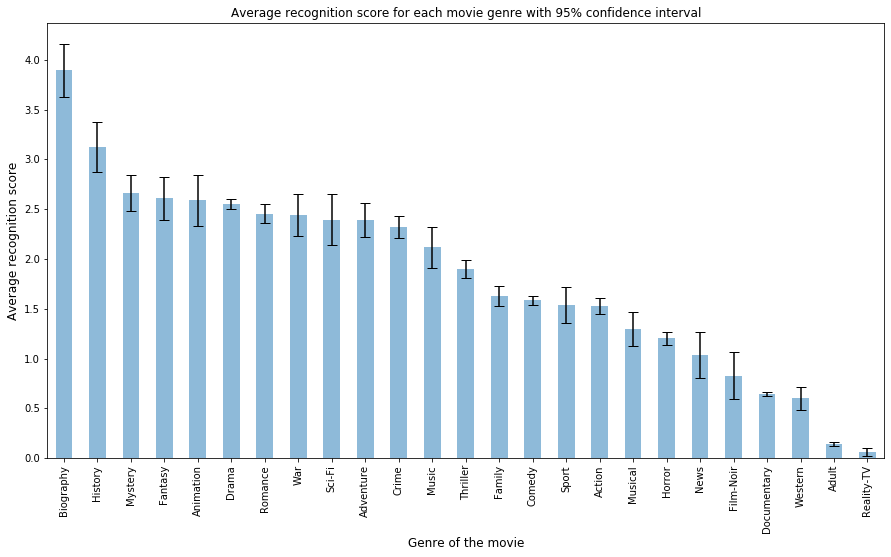

In [114]:
movies_stats_gen_rec = genres_success[genres_success['recognition']['cast_count'] > 100]['recognition']
movies_stats_gen_rec['errlo']  = movies_stats_gen_rec['nanmean'] - \
                                 movies_stats_gen_rec['95% CI mean'].apply(lambda x: x[0])

movies_stats_gen_rec['errhi']  = movies_stats_gen_rec['95% CI mean'].apply(lambda x: x[1]) -\
                                 movies_stats_gen_rec['nanmean']

movies_stats_gen_rec = movies_stats_gen_rec.sort_values('nanmean', ascending=False)

movies_stats_gen_rec.plot(kind='bar', y='nanmean', yerr=movies_stats_gen_rec[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Genre of the movie", size='large')
plt.ylabel("Average recognition score", size="large")
plt.title("Average recognition score for each movie genre with 95% confidence interval" , size="large");

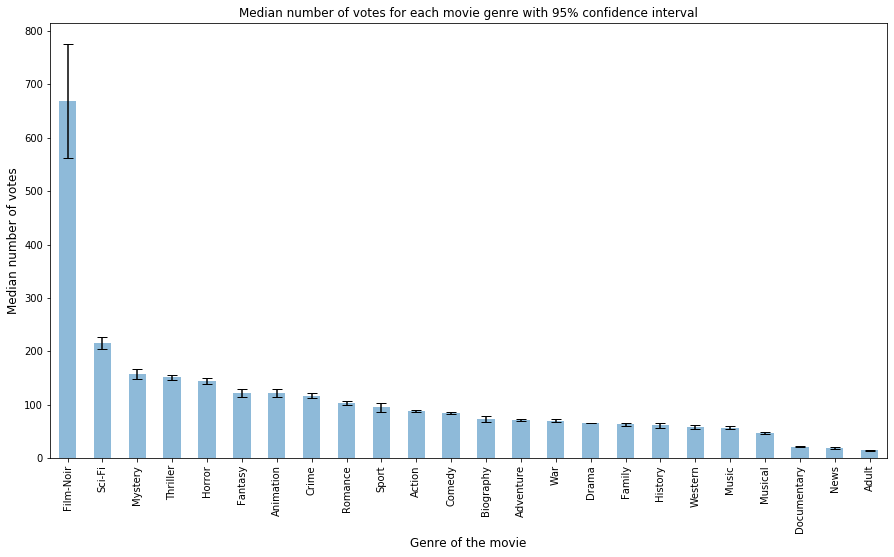

In [116]:
movies_stats_gen_vot = genres_success[genres_success['numVotes']['cast_count'] > 100]['numVotes']

movies_stats_gen_vot['errlo']  = movies_stats_gen_vot['nanmedian'] - \
                                 movies_stats_gen_vot['95% CI median'].apply(lambda x: x[0])

movies_stats_gen_vot['errhi']  = movies_stats_gen_vot['95% CI median'].apply(lambda x: x[1]) -\
                                 movies_stats_gen_vot['nanmedian']

movies_stats_gen_vot = movies_stats_gen_vot.sort_values('nanmedian', ascending=False)

movies_stats_gen_vot.plot(kind='bar', y='nanmedian', yerr=movies_stats_gen_vot[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Genre of the movie", size='large')
plt.ylabel("Median number of votes", size="large")
plt.title("Median number of votes for each movie genre with 95% confidence interval" , size="large");

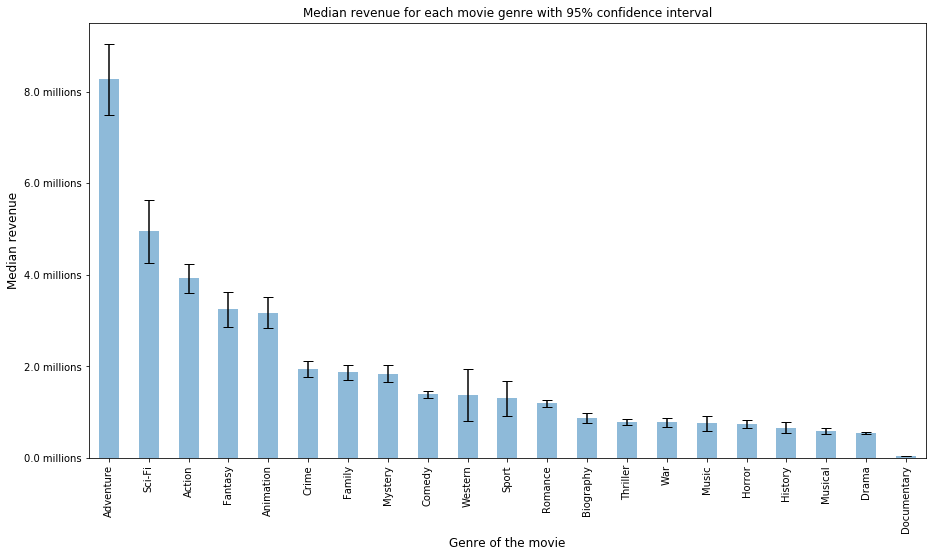

In [120]:
movies_stats_gen_wor = genres_success[genres_success['worldwideGross_adjusted']['cast_count'] > 100]\
                                                    ['worldwideGross_adjusted']

movies_stats_gen_wor['errlo']  = movies_stats_gen_wor['nanmedian'] - \
                                 movies_stats_gen_wor['95% CI median'].apply(lambda x: x[0])

movies_stats_gen_wor['errhi']  = movies_stats_gen_wor['95% CI median'].apply(lambda x: x[1]) -\
                                 movies_stats_gen_wor['nanmedian']

movies_stats_gen_wor = movies_stats_gen_wor.sort_values('nanmedian', ascending=False)

g = movies_stats_gen_wor.plot(kind='bar', y='nanmedian', yerr=movies_stats_gen_wor[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

ylabels = ['{:,.1f}'.format(x) + ' millions' for x in g.get_yticks()/1000000]
g.set_yticklabels(ylabels);

plt.xlabel("Genre of the movie", size='large')
plt.ylabel("Median revenue", size="large")
plt.title("Median revenue for each movie genre with 95% confidence interval" , size="large");